In [1]:
library(tidyverse)
library(ggplot2)
library(stringr)

library(rvest)
library(purrr)
library(polite)
library(xml2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5          ✔ purrr   0.3.4     
✔ tibble  3.1.5          ✔ dplyr   1.0.7.9000
✔ tidyr   1.1.3          ✔ stringr 1.4.0     
✔ readr   2.0.1          ✔ forcats 0.5.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




# Setting up regional population data 
This combines the Auckland, Counties Manakau and Waitemata data into one region (Auckland), as well as the Capital & Coast and Hutt valley regions into one.
Source: https://www.health.govt.nz/new-zealand-health-system/my-dhb

In [2]:
# Main url that the population data is scraped from
base_url <- 'https://www.health.govt.nz'
main_location <- '/new-zealand-health-system/my-dhb'

main_page <- read_html(paste(base_url, main_location, sep=""))

# Getting the individual page elements
DHBs <- main_page %>%
    html_elements('#block-system-main > div > div > div.panel-panel.left.col-xs-12.col-md-3.col-lg-3 > div > div > div > ul') %>%
    html_children()


# Getting the names of the DHBS from each of the elements
DHB_names <- DHBs %>%
    html_text() %>%
    str_replace_all(' DHB', '')


# Getting the DHB specific page links
DHB_sub_pages <- DHBs %>%
    html_children() %>%
    html_attr('href') %>%
    paste(base_url, ., sep="") %>%
    str_trim() %>%
    str_squish()

# Combining the Region and Link info into a dataframe
population_info <- tibble(Region = DHB_names,
                          Link = DHB_sub_pages)

In [3]:
# This function takes a link to a specific DHB page and returns the population
get_population <- function(link) {
    
    # Reading the page and getting the bulk text object (I cant just select a specific text block as the position of the information varies from page to page)
    page <- read_html(link)
    text <- page %>%
        html_elements('.field-item.even') %>%
        .[[2]] %>%
        html_children() %>%
        html_text()
    
    # Joining the list of text boxes into one large string
    combined_text <- text %>%
        paste(collapse = '') %>%
        .[[1]] %>%
        .[[1]] 

   # The layout on the auckaland page differs slightly, so the retrieving of the population number differs for it.
    if(grepl('auckland', link, fixed=TRUE)) {
        population <- combined_text %>%
        str_split('It has a population of') %>%
        .[[1]] %>%
        .[[2]] %>%
        str_split(' ') %>%
        .[[1]] %>%
        .[[1]] %>%
        str_trim() %>%
        str_split(intToUtf8(160)) %>%
        .[[1]] %>%
        .[[1]]
    } else{
        population <- combined_text %>%
        str_split('It has a population of') %>%
        .[[1]] %>%
        .[[2]] %>%
        str_split(' ') %>%
        .[[1]] %>%
        .[[2]]
        
    }
    # Parsing the population as a number
    population <- population %>%
        str_replace_all(',', '') %>%
        str_replace_all(' ', '') %>%
        as.numeric()
    
    return(population)
}

In [4]:
# Adding the population data into the dataframe
population_df <- population_info %>% 
    mutate(Population = map_dbl(Link, get_population)) %>%
    mutate(Region = str_trim(Region)) %>%
    mutate(Region = str_trim(Region))


In [5]:
population_df$Region[[6]]

[1] "Hawke’s Bay"

In [6]:
# This cell combines the Auckland, Counties Manakau and Waitemata into one large Auckland group, and combines Capital & Coast and Hutt Valley into one group.

# List of the Component DHBS
auckland_dhbs <- c('Auckland', 'Counties Manukau', 'Waitematā')
capital_coast_hutt_dhbs <- c('Capital & Coast', 'Hutt Valley')

# Getting the total population of the auckland DHBS
auckland <- population_df %>% 
    filter(Region %in% auckland_dhbs)
auckland_population <- sum(auckland$Population)

# Getting the total population of the capital and coast and hutt valley DHBS
capital_hutt <- population_df %>%
    filter(Region %in% capital_coast_hutt_dhbs)
capital_hutt_population <- sum(capital_hutt$Population)

# Replacing the component entries with the new ones
population_df <- population_df %>%
    filter(!(Region %in% auckland_dhbs)) %>%
    add_row(Region = 'Auckland', Link=NA, Population=auckland_population)

population_df <- population_df %>%
    filter(!(Region %in% capital_coast_hutt_dhbs)) %>%
    add_row(Region = 'Capital & Coast and Hutt Valley', Link=NA, Population=capital_hutt_population)    

population_df[population_df == "Tairāwhiti"] <- "Tairawhiti"


# Function to fix the Hawke's Bay name
fix_hawkes <- function(Region) {
    result <- ifelse(grepl('Hawk', Region, fixed=TRUE), 'Hawke\'s Bay', Region)
    return(result)
}

# Fixing the Hawkes bay names
population_df <- population_df %>% 
    mutate(Region = map(Region, fix_hawkes)) %>%
    mutate(Region = as.character(Region))

In [7]:
# Taking only the Region and Population data as the Link is not needed
population_data <- population_df %>% 
    select(Region, Population)

# Showing the data in its useable form
population_data %>%
    arrange(Region)

Region,Population
<chr>,<dbl>
Auckland,1701410
Bay of Plenty,259090
Canterbury,578290
Capital & Coast and Hutt Valley,477430
Hawke's Bay,176110
Lakes,116370
MidCentral,186190
Nelson Marlborough,159360
Northland,193170


In [8]:
# Regions <- c('Auckland', 'Bay of Plenty', 'Canterbury', 'Capital & Coast and Hutt Valley', 'Lakes', 'MidCentral', 'Nelson Marlborough', 'Northland',
#                  'South Canterbury', 'Southern', 'Tairawhiti', 'Taranaki', 'Waikato', 'Wairarapa', "Hawke's Bay", 'West Coast', 'Whanganui')
# Region_Populations <- c(493990 + 578650 + 628770, 259090, 578290, 320640 + 156790, 116370, 186190, 159360, 193170, 61955, 344900, 49755, 124380, 435490, 48480, 
#               176110, 32550, 68395)

# population_data <- tibble(Region = Regions,
#                         Population = Region_Populations)

# Getting Vaccine data ready

In [9]:
# This downloads the ministry of health nz-covid-data github into a file called 'nzCovidData.zip' and then unzips it
download.file(url='https://codeload.github.com/minhealthnz/nz-covid-data/zip/refs/heads/main', 
             destfile='nzCovidData.zip')
unzip(zipfile='nzCovidData.zip')

In [10]:
# This cell navigates into the unzipped ministry of health covid data, and then extracts the 'doses_group_and_dhb_service.csv' file
# Which is the file with regional vaccine data.

home_dir <- getwd() # Stores current working directory
goal_dir <- paste(home_dir, '/nz-covid-data-main/vaccine-data/latest', sep="")  # Combining current directory, and the location of the desired file in the covid data

setwd(goal_dir) # Chanding to desired directory
vaccination_data_raw <- 'doses_group_and_dhb_service.csv' %>%  # Reading the appropriate file into a varaible
    read_csv() 

setwd(home_dir) # Returning to the original working directory


Rows: 3412 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Group, DHB of service
dbl  (2): Dose number, # doses administered
date (1): Week ending

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Wrangling the vaccination data to align with the population data

In [11]:
# This cell mutates the vaccination data into a form that joins with the population data nicely and correctly (I believe)

vaccination_data <- vaccination_data_raw %>%
    select("Week ending", "Group", 'DHB of service', 'Dose number', '# doses administered') # Taking only the desired info

new_col_names = c('Week', 'Group', 'Region', 'Dose', 'Volume') # Renaming the columns for ease of use and clarity
colnames(vaccination_data) <- new_col_names

vaccination_data <- vaccination_data %>% 
    filter(Dose == 1) %>%  # Taking data on only the first dose numbers
    mutate(Region = ifelse(Region == 'Auckland Metro', 'Auckland', Region)) %>% # Renaming 'Auckland Metro' to 'Auckland'
    filter(Region != 'Other Sites') # Removing the 'Other' data 

# Function to fix the Hawke's Bay name
fix_Hawkes <- function(Region) {
    result <- ifelse(grepl('Hawk', Region, fixed=TRUE), 'Hawke\'s Bay', Region)
    return(result)
}
# Fixing the hawkes bay names
vaccination_data <- vaccination_data %>% 
    mutate(Region = map(Region, fix_Hawkes)) %>%
    mutate(Region = as.character(Region))

# Combining Vaccination and Population data + plotting some results

In [12]:
joined_vaccination_data <- vaccination_data %>%
    left_join(population_data, by = 'Region')

joined_vaccination_data %>% 
    sample_n(5)

Week,Group,Region,Dose,Volume,Population
<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2021-05-02,Group 1,Auckland,1,1857,1701410
2021-04-04,Group 3,Nelson Marlborough,1,678,159360
2021-08-15,Group 1,Taranaki,1,7,124380
2021-06-20,Group 4,Canterbury,1,142,578290
2021-06-13,Group 1,Lakes,1,51,116370


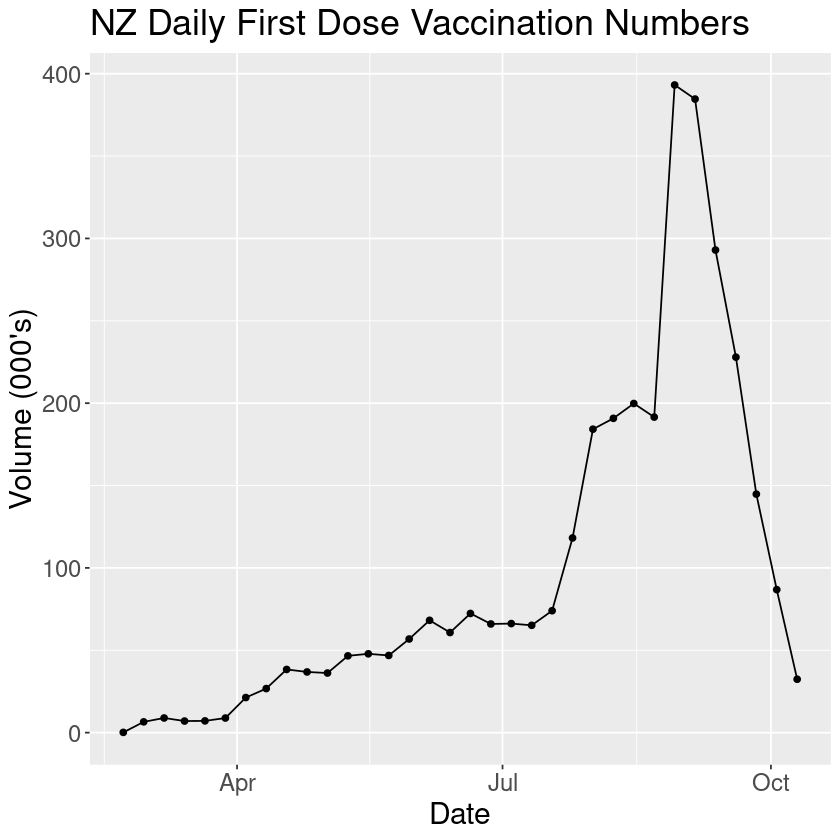

In [13]:
# This cell just plots the total weekly vaccination numbers (first dose, non-cumlative)


# Taking the weekely total vaccination numbres
vaccination_overall_rates <- vaccination_data %>%
    group_by(Week) %>%
    summarise(Volume = sum(Volume))

# Modifiying the vaccination numbers to represent thousands (Just displays nicer)
vaccination_overall_rates_000 <- vaccination_overall_rates %>%
    mutate(Volume = Volume/1000)


# Plotting
ggplot(data = vaccination_overall_rates_000,
      aes(x = Week,
          y = Volume)) +
    geom_line() +
    geom_point() +
    xlab('Date') +
    ylab('Volume (000\'s)') +
    ggtitle("NZ Daily First Dose Vaccination Numbers") + 
    theme(text = element_text(size=18))

`summarise()` has grouped output by 'Week'. You can override using the `.groups` argument.


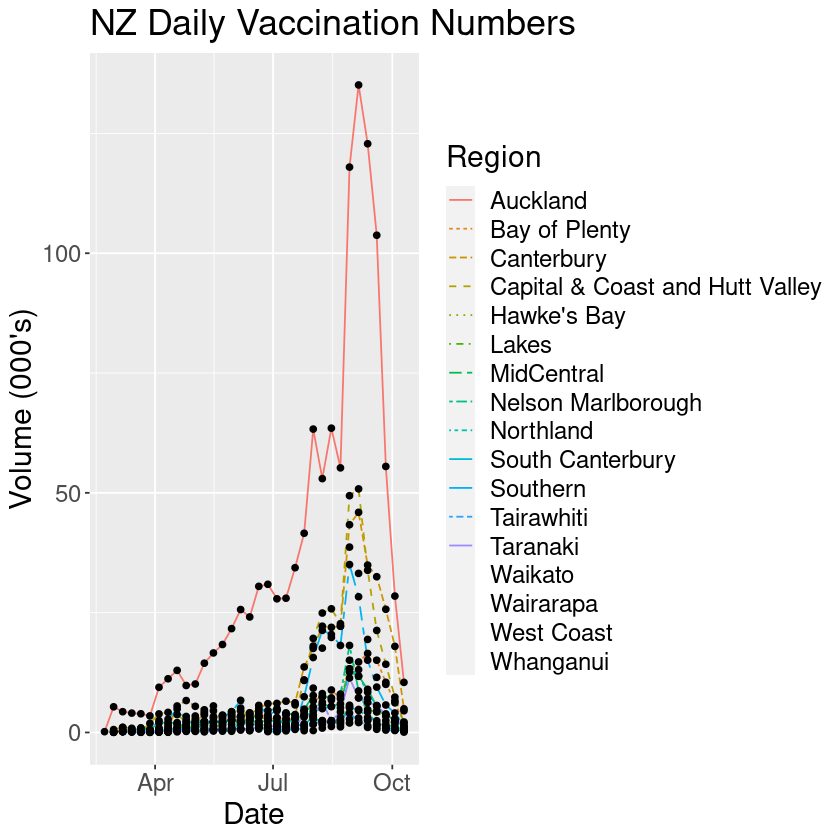

In [14]:
# This cell plots regional weekly vaccination numbers

vac_regional_rates <- vaccination_data %>%
    group_by(Week, Region) %>%
    summarise(Volume = sum(Volume)/1000)


# NOTE: This is messy and more just here to check if this works 8) 
ggplot(data = vac_regional_rates,
      aes(x = Week,
          y = Volume,
          group=Region)) +
    geom_line(aes(linetype=Region, color=Region)) +
    geom_point() +
    xlab('Date') +
    ylab('Volume (000\'s)') +
    ggtitle("NZ Daily Vaccination Numbers") + 
    theme(text = element_text(size=18)) 
    


`summarise()` has grouped output by 'Week'. You can override using the `.groups` argument.


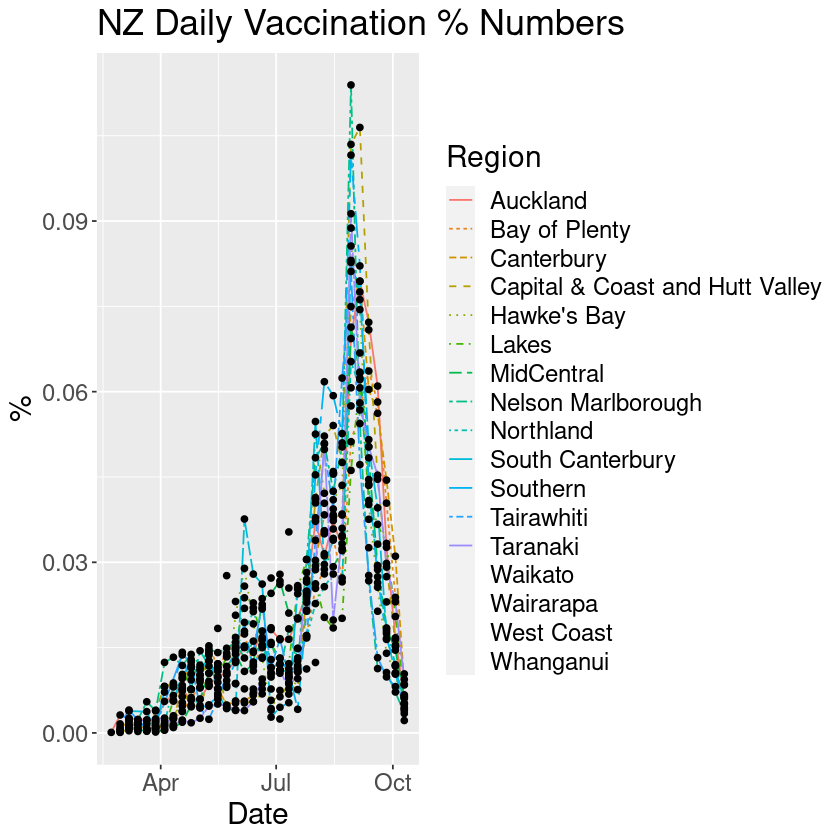

In [15]:
# This cell plots the same data as the above cell, but in percentages instead of raw values

# Mutating the data
percent_vaccination_data <- joined_vaccination_data %>%
    mutate(Percent = Volume/Population) %>%
    group_by(Week, Region) %>%
    summarise(Total = sum(Percent))


# NOTE: as with the above graph, this is messy and more just here to check if this works 8) 
ggplot(data = percent_vaccination_data,
      aes(x = Week,
          y = Total,
          group=Region)) +
    geom_line(aes(linetype=Region, color=Region)) +
    geom_point() +
    xlab('Date') +
    ylab('%') +
    ggtitle("NZ Daily Vaccination % Numbers") + 
    theme(text = element_text(size=18)) 
    
